# Question n°1

In [1]:
#We generate from an alpha distribution with jax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:


def simulation_alpha_stable_mc(alpha: float, beta: float, gamma: float, delta: float, n: int, key):
    """
    Generate n samples from an alpha-stable distribution with parameters alpha, beta, gamma, delta 
    using the Chambers–Mallows–Stuck method.

    Parameters:
        alpha (float): Stability parameter (0 < alpha <= 2).
        beta (float): Skewness parameter (-1 <= beta <= 1).
        gamma (float): Scale parameter.
        delta (float): Location parameter.
        n (int): Number of samples to generate.
        key (jax.random.PRNGKey): JAX random key.
        
    Returns:
        jnp.ndarray: A vector of n samples from the specified alpha-stable distribution.

    example:
        key = jax.random.PRNGKey(0)
        alpha = 1.5
        beta = 0.5
        gamma = 1.0
        delta = 0.0
        n = 10000
        samples = simulation_alpha_stable(alpha, beta, gamma, delta, n, key)

    """
    # Split the key to get independent streams for generating different random variables.
    key_u, key_w = jax.random.split(key)

    half_pi = jnp.pi / 2

    # Generate the required random variables.
    w = jax.random.exponential(key_w, shape=(n,))
    u = jax.random.uniform(key_u, minval=-half_pi, maxval=half_pi, shape=(n,))

    epsi = 1e-6  # Tolerance for comparing alpha with 1

    def branch_alpha_eq_1():
        # Formula for alpha == 1
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u) -
            beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def branch_alpha_neq_1():
        # Parameters used for the Chambers–Mallows–Stuck formula (alpha != 1)
        S = (1 + beta**2 * jnp.tan(half_pi * alpha)**2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return S * (jnp.sin(alpha * (u + B)) / (jnp.cos(u)) ** (1 / alpha)) * (
            (jnp.cos(u - alpha * (u + B)))/w
        ) ** ((1 - alpha) / alpha)

    # Choose the appropriate branch based on alpha.
    y = jax.lax.cond(jnp.abs(alpha - 1) < epsi, branch_alpha_eq_1, branch_alpha_neq_1)

    return gamma * y + delta


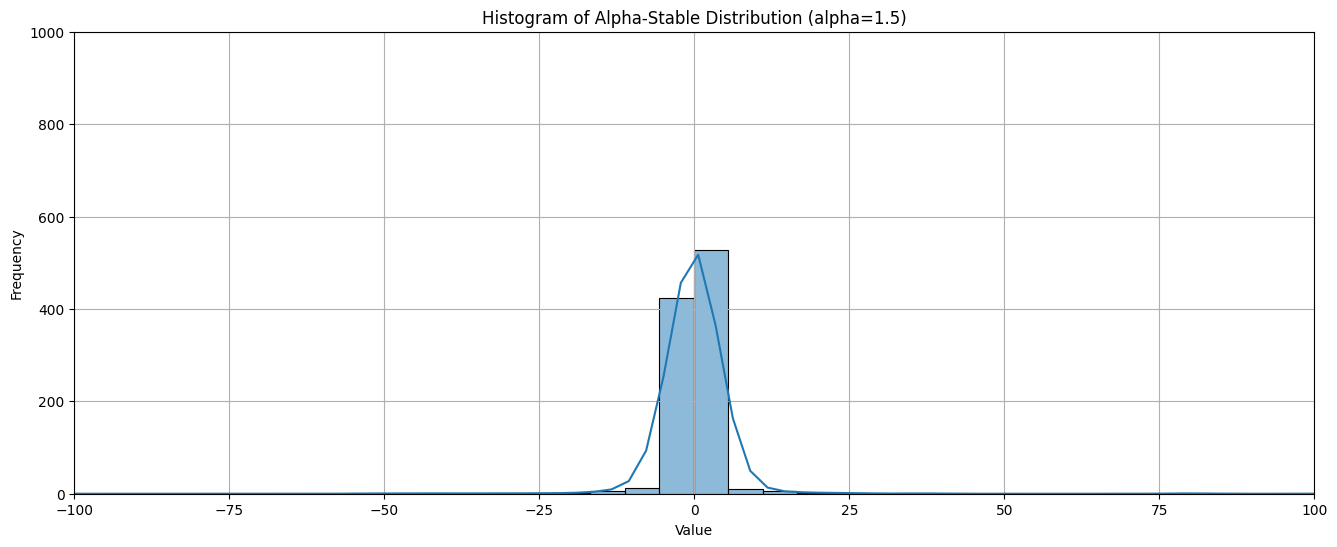

In [3]:
y = simulation_alpha_stable_mc(1, 0, 0.5, 0, 1000, jax.random.PRNGKey(2))
# Plotting the histogram
plt.figure(figsize=(16, 6))
sns.histplot(y, bins=100, kde=True)
plt.title('Histogram of Alpha-Stable Distribution (alpha=1.5)')
plt.xlabel('Value')
plt.xlim(-100,100)
plt.ylabel('Frequency')

plt.ylim(0, 1000)
plt.grid()
plt.show()

# Question n°2

To generate n samples from an  alpha-stable, it is needed to sample from an Exp(1) and a Uniform(-pi/2 , pi/2), so this is where using RQMC is usefull. Indeed, instead of sampling from this laws, it is possible to use a Sobol sequence with scrambling.

Once this is done, there are two variables u,v \in [0,1]^2.

To get the u that is required, the following transformation is used : u' = u*pi - pi/2 //
To get the w that is required, the following transformation is used : w = -log(v)  (inverse CDF)

Then with the correct u and w, it is possible to generate the alpha-stable sample following the method from before.

In [4]:
import jax.numpy as jnp
import jax
import numpy as np
from scipy.stats import qmc

def simulation_alpha_stable_rqmc(alpha: float, beta: float, gamma: float, delta: float, n: int, seed : int = None):
    """
    Generate n samples from an alpha-stable distribution using an RQMC sequence.
    
    Parameters:
        alpha (float): Stability parameter (0 < alpha <= 2).
        beta (float): Skewness parameter (-1 <= beta <= 1).
        gamma (float): Scale parameter.
        delta (float): Location parameter.
        n (int): Number of samples to generate.
    
    Returns:
        jnp.ndarray: A vector of n samples from the specified alpha-stable distribution.
    """
    # 1. Generate a 2D Sobol sequence with scrambling (RQMC)
    sampler = qmc.Sobol(d=2, scramble=True)
    # Generate n points in [0,1]^2
    points = sampler.random(n)
    
    # 2. Transform the first coordinate to [-pi/2, pi/2] for u
    half_pi = jnp.pi / 2
    # Note: Convert the numpy array to a jax array if necessary
    u = jnp.array(points[:, 0]) * jnp.pi - half_pi
    
    # 3. Transform the second coordinate via the inverse CDF to get exponential variables
    v = jnp.array(points[:, 1])
    # Avoid issues with logarithm of zero by adding a small epsilon if needed.
    epsilon = 1e-10
    w = -jnp.log(v + epsilon)
    
    # 4. Calculate y using the Chambers–Mallows–Stuck method
    tol = 1e-6  # tolerance for checking if alpha ~ 1
    
    def branch_alpha_eq_1():
        return (2 / jnp.pi) * (
            (half_pi + beta * u) * jnp.tan(u) -
            beta * jnp.log((half_pi * w * jnp.cos(u)) / (half_pi + beta * u))
        )

    def branch_alpha_neq_1():
        S = (1 + beta**2 * jnp.tan(half_pi * alpha)**2) ** (1 / (2 * alpha))
        B = (1 / alpha) * jnp.arctan(beta * jnp.tan(half_pi * alpha))
        return S * (jnp.sin(alpha * (u + B)) / (jnp.cos(u)) ** (1/alpha)) * (
            (jnp.cos(u - alpha * (u + B))) / w
        ) ** ((1 - alpha) / alpha)
    
    y = jax.lax.cond(jnp.abs(alpha - 1) < tol, branch_alpha_eq_1, branch_alpha_neq_1)
    
    # 5. Apply the scale and location transformation.
    return gamma * y + delta


Standard Monte Carlo estimates of E[cos(Y)]:
Mean: 0.356933, Std. Dev.: 0.009396

RQMC estimates of E[cos(Y)]:
Mean: 0.355990, Std. Dev.: 0.001149


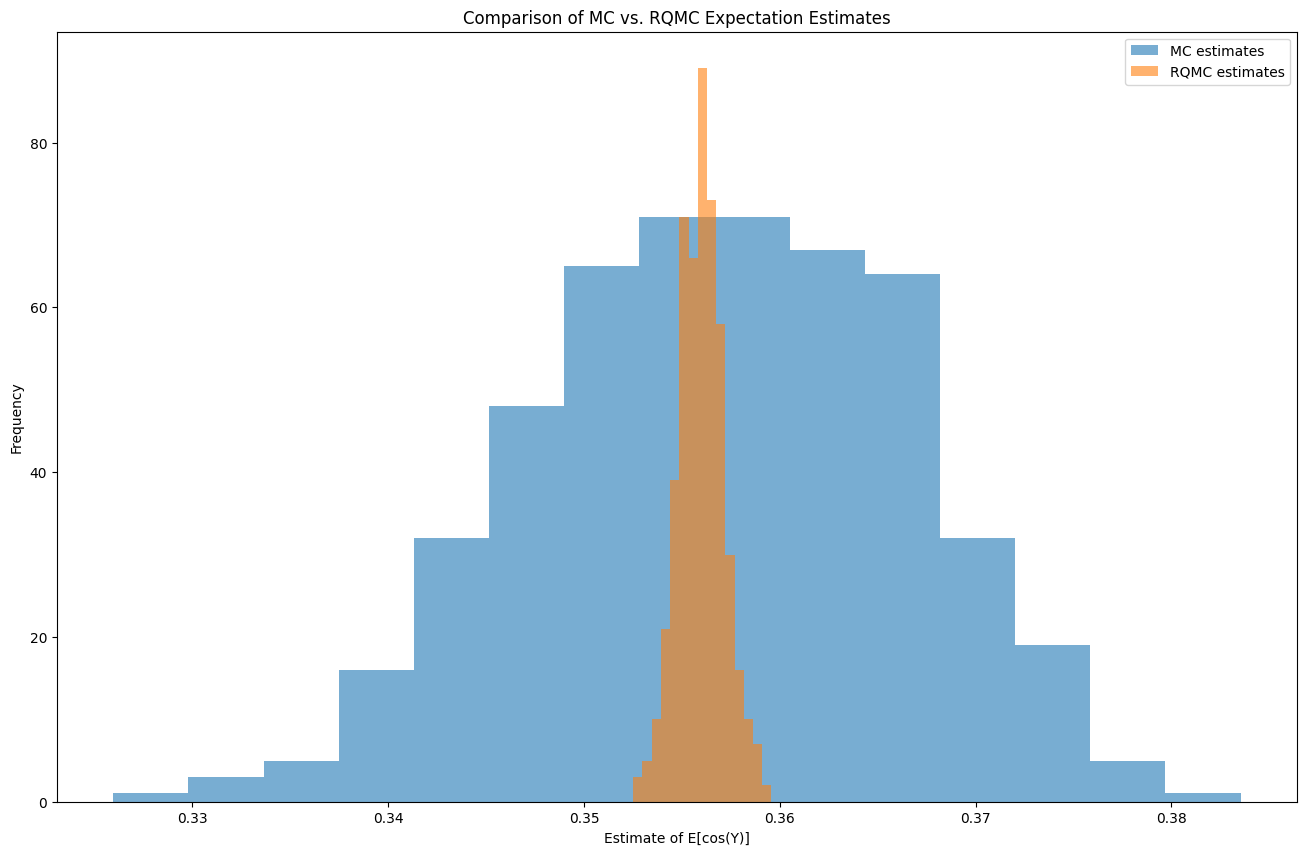

In [5]:
def g(y):
    """
    Bounded function for which to compute the expectation.
    Here, we use g(y) = cos(y).
    """
    return jnp.cos(y)


def estimate_expectation_mc(alpha, beta, gamma, delta, n, reps):
    """ 
    Compute expectation estimates under the alpha-stable distribution using standard MC.
    """
    estimates = []
    for i in range(reps):
        # Use a different seed for each replication.
        key = jax.random.PRNGKey(i)
        samples = simulation_alpha_stable_mc(alpha, beta, gamma, delta, n, key)
        estimates.append(jnp.mean(g(samples)))
    return jnp.array(estimates)


def estimate_expectation_rqmc(alpha, beta, gamma, delta, n, reps, base_seed=123):
    """ 
    Compute expectation estimates under the alpha-stable distribution using RQMC.
    For each replication, reinitialize the scrambled Sobol generator with a different seed.
    """
    estimates = []
    for i in range(reps):
        seed = base_seed + i  # vary the seed for different scrambling
        samples = simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n, seed)
        estimates.append(jnp.mean(g(samples)))
    return jnp.array(estimates)

#------------------------------------------------------------------------------
# Comparison of MC vs. RQMC estimates
#------------------------------------------------------------------------------

# Parameters for the alpha-stable distribution
alpha = 1.7
beta = 0.5
gamma = 1.0
delta = 0.0
n_samples = 4096  # number of samples per replication (power of 2 for Sobol)
n_replications = 500  # number of replications

# Compute expectation estimates via MC and RQMC
mc_estimates = estimate_expectation_mc(alpha, beta, gamma, delta, n_samples, n_replications) 
rqmc_estimates = estimate_expectation_rqmc(alpha, beta, gamma, delta, n_samples, n_replications)

# Calculate statistics (mean and standard deviation over replications)
mc_mean = float(jnp.mean(mc_estimates))
mc_std  = float(jnp.std(mc_estimates))
rqmc_mean = float(jnp.mean(rqmc_estimates))
rqmc_std  = float(jnp.std(rqmc_estimates))

print("Standard Monte Carlo estimates of E[cos(Y)]:")
print(f"Mean: {mc_mean:.6f}, Std. Dev.: {mc_std:.6f}")
print("\nRQMC estimates of E[cos(Y)]:")
print(f"Mean: {rqmc_mean:.6f}, Std. Dev.: {rqmc_std:.6f}")

#------------------------------------------------------------------------------
# Plotting the distribution of estimates for a visual comparison
#------------------------------------------------------------------------------
plt.figure(figsize=(16,10))
plt.hist(mc_estimates, bins=15, alpha=0.6, label='MC estimates', color='C0')
plt.hist(rqmc_estimates, bins=15, alpha=0.6, label='RQMC estimates', color='C1')
plt.xlabel("Estimate of E[cos(Y)]")
plt.ylabel("Frequency")
plt.title("Comparison of MC vs. RQMC Expectation Estimates")
plt.legend()
plt.show() 

As expected, the variance is way smaller when RQMC is used.

Question n°3

In [ ]:
def prior_sample(N):
    """
    Tire N échantillons (theta) selon la loi a priori.
    Exemple: on suppose alpha ~ Uniform(0,2), beta ~ Uniform(-1,1),
             gamma ~ Lognormal(0,1), delta ~ Normal(0,5)
    On renvoie un tableau shape (N, 4).
    """
    alpha_samples = np.random.uniform(0.1, 2.0, size=N)   # on évite alpha < 0.1
    beta_samples  = np.random.uniform(-1.0, 1.0, size=N)
    gamma_samples = np.random.lognormal(mean=0.0, sigma=1.0, size=N)
    delta_samples = np.random.normal(loc=0.0, scale=5.0, size=N)
    return np.column_stack((alpha_samples, beta_samples, gamma_samples, delta_samples))

def simulate_data(theta, n):
    """
    Simule n données selon la distribution alpha-stable définie par theta = (alpha,beta,gamma,delta).
    Ici, on utiliserait par ex. la fonction Chambers–Mallows–Stuck ou un sampler existant.
    """
    alpha, beta, gamma, delta = theta
    #  code qui génère un tableau x shape (n,)
    # (voir pour utiliser un simulateur stable, PyStan, ou un code personnel)
    x = simulation_alpha_stable_rqmc(alpha, beta, gamma, delta, n) 
    return x

def mcculloch_estimator(x):
    x.sort()
    n = len(x)


def mcculloch_summary(x):
    """
    Calcule l’estimateur de McCulloch (ou un vecteur de 4 nombres)
    qui correspondent aux estimations de (alpha, beta, gamma, delta) à partir de x.
    """
    # Chercher l'estimateur de McCulloch pour alpha, beta, gamma, delta
    # (voir le papier de McCulloch, 1986)
    alpha_hat, beta_hat, gamma_hat, delta_hat = mcculloch_estimator(x)
    return np.array([alpha_hat, beta_hat, gamma_hat, delta_hat])

def distance_function(s_sim, s_obs):
    """
    Calcule la distance entre les deux vecteurs de summary stats.
    Par exemple la norme L2, ou L1, etc.
    """
    return np.linalg.norm(s_sim - s_obs, ord=2)

def abc_rejection(y_obs, N, n_sim, epsilon):
    """
    y_obs: données observées
    N: nombre de tirages de la prior à considérer
    n_sim: taille de l'échantillon simulé pour chaque theta
    epsilon: seuil ABC

    Sortie: liste (ou np.array) des theta acceptés
    """

    # 1) Calculer la statistique résumée pour les données observées
    s_obs = mcculloch_summary(y_obs)

    # 2) Échantillonner N valeurs de theta selon la prior
    thetas = prior_sample(N)

    # Tableau pour stocker les thetas acceptés
    accepted_thetas = []

    for i in range(N):
        theta_i = thetas[i]
        # 3) Simuler un échantillon x_i
        x_i = simulate_data(theta_i, n_sim)
        # 4) Calculer la statistique résumée sur x_i
        s_i = mcculloch_summary(x_i)
        # 5) Calculer la distance et comparer à epsilon
        dist = distance_function(s_i, s_obs)
        if dist < epsilon:
            accepted_thetas.append(theta_i)

    return np.array(accepted_thetas)
